In [1]:
import os
import pandas as pd
import numpy as np
import hdbscan
from sklearn.preprocessing import LabelBinarizer

from clustering_evaluation import ClusterPurity

# Loading The Dataset:

In [2]:
# -- load the input dataset--#
input_df=pd.read_csv('/home/daikiri/DAIKIRI/src/Hamada/merged.csv', low_memory=True)
input_df.index = 'Event_' + input_df.index.astype(str)
num_rows, num_cols = input_df.shape  # at max num_rows times num_cols columns.
column_names = input_df.columns
    
print ('Input data loaded with shape', input_df.shape)     

/home/daikiri/.conda/envs/daikiri/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Input data loaded with shape (2974716, 41)


In [ ]:
# binarize string_labels in ['type']
lb=LabelBinarizer()
event_labels=lb.fit_transform(input_df['type'].tolist())
lb.classes_


<AxesSubplot:>

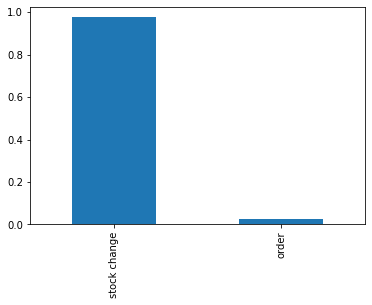

In [19]:
pd.value_counts(input_df['type'], normalize=True).plot.bar()

## Load The Embedding Input Data:

In [3]:
#-- load the embeddings data --#
embedding_input=pd.read_csv('/home/daikiri/DAIKIRI/src/Hamada/Vectograph_Results/2020-08-08 01:00:07.899851/PYKE_50_embd.csv', index_col=0, low_memory=True)

#consider only events embedding (Event_id)
embedding_index=embedding_input.index.tolist()
prefix = 'Event_'
event_ids=list(filter(lambda x: x.startswith(prefix), embedding_index))
events_df=embedding_input.loc[event_ids]

# HDBSCAN Clustering

In [4]:
def hdbscan_clustering(cluster_df):
    """
    param: Embeddings dataframe to be clustered
    return: a clustered dataframe
    """

    ##-- Cluster the data using HDBSCAN --### -- Consider Hyperparameter tuning later --#
    clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.3, approx_min_span_tree=True, metric='euclidean',
     gen_min_span_tree=True, min_cluster_size=10000, min_samples=100, cluster_selection_epsilon= 0.5, 
                                core_dist_n_jobs=1,allow_single_cluster=False).fit(cluster_df)

    #-- Save clustering results as a new column in the original dataframe --#
    cluster_df['cluster_preds']=clusterer.labels_
    
    print ('Number of Clusters: ',len(set(clusterer.labels_)))

    return cluster_df


# Clustering Performance: (cluster_purity metric)

In [5]:
def evaluate_ClusteringPurity(cluster_preds, cluster_true):
    """
    param: 
        cluster_preds: predict cluster label
        cluster_true: the ground truth labels of clusters. Here, we use 'type' column from 
        the original dataset.
        
    return purity_score
    """

    evaluator=ClusterPurity()
    purity_score=evaluator.purity_score(y_true=cluster_true, y_pred=cluster_preds)

    return purity_score


In [6]:
def cluster_distriubions(clustered_df):
    
    print('Clusters Distributions: ')
    cluster_distributions=clustered_df.groupby('cluster_preds').size()
    for cluster, size in cluster_distributions.items():
        print (cluster, size)


# Evaluation Results:

In [7]:
 #-- Clustering using HDBSCAN --#
clustered_df=hdbscan_clustering(events_df)

cluster_preds= events_df['cluster_preds'].tolist()
cluster_true= input_df['type'].tolist()

#-- Evaluate the clustering performance --#
purity_score=evaluate_ClusteringPurity(cluster_preds, cluster_true)
print('Clustering Purity Score: ', purity_score)
    
# -- Print Cluster Distributions --#
cluster_distriubions(clustered_df)


Number of Clusters:  3
Clustering Purity Score:  0.9760810779919831
Clusters Distributions: 
-1 4207
0 114947
1 2855562


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(event_labels, cluster_preds)
print('Accuracy: %f' % accuracy)

precision = precision_score(event_labels, cluster_preds, average='macro')
print('Precision: %f' % precision)

recall = recall_score(event_labels, cluster_preds, average='macro')
print('Recall: %f' % recall)

f1 = f1_score(event_labels, cluster_preds, average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.936376
Precision: 0.326482


/home/daikiri/.conda/envs/daikiri/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall: 0.321963
F1 score: 0.324100


/home/daikiri/.conda/envs/daikiri/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


[Text(0, 0.5, 'stock change'), Text(0, 1.5, 'order')]

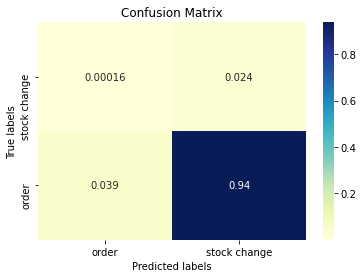

In [14]:
#------------- Confusion Matrix ------------------#
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt  

labels=[0, 1]
cm= confusion_matrix(event_labels, cluster_preds, labels, normalize='all')
ax= plt.subplot()

sns.heatmap(cm, annot=True, ax = ax, cmap="YlGnBu"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['order', 'stock change'])
ax.yaxis.set_ticklabels(['stock change', 'order'])